In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import ROOT
import h5py

In [4]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from uncertainties import ufloat, unumpy

In [6]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))

In [7]:
TYPE = 14
TYPE_S = {14: 'numu', 12: 'nue'}
DEFAULT_FILE_PATH = '/data/mandalia/hadron_xsec_pythia/default/'+TYPE_S[TYPE]+'/gntp.1.gst.root'
MODIFIED_FILE_PATH = '/data/mandalia/hadron_xsec_pythia/pythia_parms/'+TYPE_S[TYPE]+'/gntp.1.gst.root'
N_INDEX = 1.33

In [8]:
input_file_d = ROOT.TFile(DEFAULT_FILE_PATH)
input_file_m = ROOT.TFile(MODIFIED_FILE_PATH)

STR_R = ['Ev', 'El', 'neu', 'y', 'W', 'pdgf', 'nf', 'Ef', 'pxf', 'pyf', 'pzf', 'wght']
SUB_STR = ['Ef', 'pxf', 'pyf', 'pzf', 'pdgf']
default_dict, modified_dict = {key: [] for key in STR_R}, {key: [] for key in STR_R}

for event in input_file_d.gst:
    if event.dis and event.cc:
        for parm in STR_R:
            if parm in SUB_STR:
                default_dict[parm].append(list(event.__getattr__(parm)))
            else:
                default_dict[parm].append(event.__getattr__(parm))
for event in input_file_m.gst:
    if event.dis and event.cc:
        for parm in STR_R:
            if parm in SUB_STR:
                modified_dict[parm].append(list(event.__getattr__(parm)))
            else:
                modified_dict[parm].append(event.__getattr__(parm))

for key in default_dict.iterkeys(): default_dict[key] = np.array(default_dict[key])
for key in modified_dict.iterkeys(): modified_dict[key] = np.array(modified_dict[key])

In [9]:
print(default_dict['Ev'].shape)
print(modified_dict['Ev'].shape)

(1000000,)
(1000000,)


In [10]:
def calculate_p2(px, py, pz):
    sqr = lambda x: np.power(x, 2)
    return np.array(map(sqr, px)) + np.array(map(sqr, py)) + np.array(map(sqr, pz))

def calculate_beta(energy, px, py, pz):
    p2 = calculate_p2(px, py, pz)
    if np.any(energy < 0):
        raise ValueError('energy < 0! {0}'.format(energy))
    beta2 = p2 / np.array(map(lambda x: np.power(x, 2), energy))
    beta = np.array(map(np.sqrt, beta2))
    return beta

In [11]:
sqr = lambda x: np.power(x, 2)
default_mass2 = np.array(map(sqr, default_dict['Ef'])) - calculate_p2(default_dict['pxf'], default_dict['pyf'], default_dict['pzf'])
modified_mass2 = np.array(map(sqr, modified_dict['Ef'])) - calculate_p2(modified_dict['pxf'], modified_dict['pyf'], modified_dict['pzf'])

for m in default_mass2:
    assert(np.sum([m < -0.0001]) == 0)
    m[m < 0] = 0
for m in modified_mass2:
    assert(np.sum([m < -0.0001]) == 0)
    m[m < 0] = 0

default_kin = default_dict['Ef'] - np.array(map(np.sqrt, default_mass2))
modified_kin = modified_dict['Ef'] - np.array(map(np.sqrt, modified_mass2))

In [12]:
default_beta = calculate_beta(default_dict['Ef'], default_dict['pxf'], default_dict['pyf'], default_dict['pzf'])
modified_beta = calculate_beta(modified_dict['Ef'], modified_dict['pxf'], modified_dict['pyf'], modified_dict['pzf'])

default_above_thres = [beta > 1 / N_INDEX for beta in default_beta]
modified_above_thres = [beta > 1 / N_INDEX for beta in modified_beta]

In [13]:
default_pdg = default_dict['pdgf']
modified_pdg = modified_dict['pdgf']
print(set(np.hstack(default_pdg)))
ignore = np.array([-2112, -12, 111, 130, 311, 421, 2112, 3122])

default_pdg_mask, modified_pdg_mask = [], []
for pdgs in default_pdg:
    mask = []
    for pdg in pdgs:
        if pdg in ignore: mask.append(False)
        else: mask.append(True)
    default_pdg_mask.append(np.array(mask))
for pdgs in modified_pdg:
    mask = []
    for pdg in pdgs:
        if pdg in ignore: mask.append(False)
        else: mask.append(True)
    modified_pdg_mask.append(np.array(mask))

set([-2112, 130, 22, 11, 12, 13, 3222, 2212, -211, 3122, 311, -321, 2112, 321, -311, -3122, 211, -2212, 111, -14, -13, -12, -11])


In [14]:
print(default_kin[0])
for idx, kins in enumerate(default_kin): default_kin[idx] = kins[default_above_thres[idx] & default_pdg_mask[idx]]
for idx, kins in enumerate(modified_kin): modified_kin[idx] = kins[modified_above_thres[idx] & modified_pdg_mask[idx]]
print(default_kin[0])

[ 11.31596338   1.74688512  13.62482052  23.69955507  31.13763237
   0.53283589   0.19537248   0.15145036   3.07648677   0.5358968
   0.15029472   0.32958066]
[ 11.31596338   1.74688512  13.62482052  23.69955507   0.53283589
   0.15145036   3.07648677   0.5358968 ]


In [15]:
default_kin_sum = np.array(map(np.sum, default_kin))
modified_kin_sum = np.array(map(np.sum, modified_kin))

In [16]:
print(default_kin_sum)
print(modified_kin_sum)

[  54.68389389   10.13346176   56.94677528 ...,    3.72999271   38.23273136
  149.57195309]
[ 76.49050317  65.15549353   1.86357061 ...,   4.17799596  50.65965159
   7.03573756]


In [17]:
default_yeff = default_kin_sum / (default_kin_sum + default_dict['El'])
modified_yeff = modified_kin_sum / (modified_kin_sum + modified_dict['El'])
print(default_yeff.shape)
print(modified_yeff.shape)

(1000000,)
(1000000,)


In [18]:
def is_linear(edges, maxdev=1e-5):
    """
    Check whether the bin edges are evenly spaced on a linear scale
    """
    # Only 1 bin: might as well be linear
    if len(edges) < 3:
        return True
    bin_widths = np.diff(edges)
    return np.allclose(bin_widths, bin_widths[0], rtol=maxdev)

def get_bin_centers(bin_edges):
    if is_linear(bin_edges):
        return (bin_edges[:-1] + bin_edges[1:])/2.
    else:
        return np.sqrt(bin_edges[:-1] * bin_edges[1:])

In [19]:
def make_plot(energy_nw, energy_w, binning, ylabel, legendlabel, outname, a):
    centers = get_bin_centers(binning)
    
    fig = plt.figure(figsize=[10, 7])
    if TYPE == 14:
        fig.suptitle('numu', y=1.005)
    elif TYPE == 12:
        fig.suptitle('nue', y=1.005)
        
    gs = gridspec.GridSpec(2, 1)
    gs.update(hspace=0., wspace=0.)
    
    ax0 = fig.add_subplot(gs[0])
    ax0.set_xlim(np.min(binning), np.max(binning))
    if not is_linear(binning):
        ax0.set_xscale('log')
    #ax0.set_ylim([0, 250])
    for xmaj in ax0.xaxis.get_majorticklocs():
        ax0.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax0.yaxis.get_majorticklocs():
        ax0.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    ax0.get_xaxis().set_ticks([])
    ax0.set_ylabel(ylabel, size=18)
    yticks = ax0.yaxis.get_major_ticks()
    yticks[0].set_visible(False)
    yticks[1].set_visible(False)
    
    energy_nw_0 = np.concatenate(([energy_nw[0]], energy_nw))
    energy_w_0 = np.concatenate(([energy_w[0]], energy_w))
    ax0.step(
        binning, unumpy.nominal_values(energy_nw_0), alpha=1, color='red',
        drawstyle='steps-pre', label='pythia params', linewidth=1.2, linestyle='-'
    )
    ax0.step(
        binning, unumpy.nominal_values(energy_w_0), alpha=1, color='blue',
        drawstyle='steps-pre', label=legendlabel, linewidth=1.2, linestyle='-'
    )
    ax0.errorbar(
        centers, unumpy.nominal_values(energy_nw),
        xerr=0, yerr=unumpy.std_devs(energy_nw),
        capsize=0.7, alpha=1, color='red', linestyle='None', markersize=0.5, linewidth=1
    )
    ax0.errorbar(
        centers, unumpy.nominal_values(energy_w),
        xerr=0, yerr=unumpy.std_devs(energy_w),
        capsize=0.7, alpha=1, color='blue', linestyle='None', markersize=0.5, linewidth=1
    )
    ax0.legend()
    
    text = r'hadron_DIS = {0}'.format(a)
    at = AnchoredText(text, prop=dict(size=10), frameon=True, loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax0.add_artist(at)

    ax1 = fig.add_subplot(gs[1])
    if not is_linear(binning):
        ax1.set_xscale('log')
    ax1.set_xlim(np.min(binning), np.max(binning))
    ax1.set_xlabel(r'$y_{eff}$', size=18)
    ax1.set_ylabel('ratio', size=18)
    ax1.set_ylim([0.8, 1.2])
    for xmaj in ax1.xaxis.get_majorticklocs():
        ax1.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax1.yaxis.get_majorticklocs():
        ax1.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    
    inv_mask = ~default_hist.mask & ~modified_hist.mask
    ratio = unumpy.uarray(np.zeros(default_hist.shape).astype(float), np.zeros(default_hist.shape).astype(float))
    
    ratio[inv_mask] = energy_w[inv_mask] * (1 / energy_nw[inv_mask])
    ratio = ma.masked_equal(ratio, 0)

    ratio_0 = np.concatenate(([ratio[0]], ratio))
    ax1.step(
        binning, unumpy.nominal_values(ratio_0), alpha=1, color='blue',
        drawstyle='steps-pre', linewidth=1.2, linestyle='-'
    )
    ax1.step(
        binning, np.ones(ratio_0.shape), alpha=1,
        color='red', drawstyle='steps-pre', linewidth=1.2, linestyle='-'
    )
    ax1.errorbar(
        centers, unumpy.nominal_values(ratio),
        xerr=0, yerr=unumpy.std_devs(ratio),
        capsize=0.7, alpha=1, color='blue', linestyle='None', markersize=0.5, linewidth=1
    )

    fig.tight_layout()
    fig.savefig('./images/hadronization/'+outname, bbox_inches='tight')

In [20]:
def make_histo(array, binning, weights):
    hist, edges = np.histogram(array, bins=binning, weights=weights)
    hist_2, edges = np.histogram(array, bins=binning, weights=weights**2)

    u_hist = unumpy.uarray(hist, np.sqrt(hist_2))
    return ma.masked_equal(u_hist, 0)

[ 0.49030718  0.12887986  0.78205649 ...,  0.12950715  0.77234321
  0.18647404]
[ 0.99999449  0.99246163  0.99999998 ...,  0.99255491  0.99999998
  0.99760522]


/data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


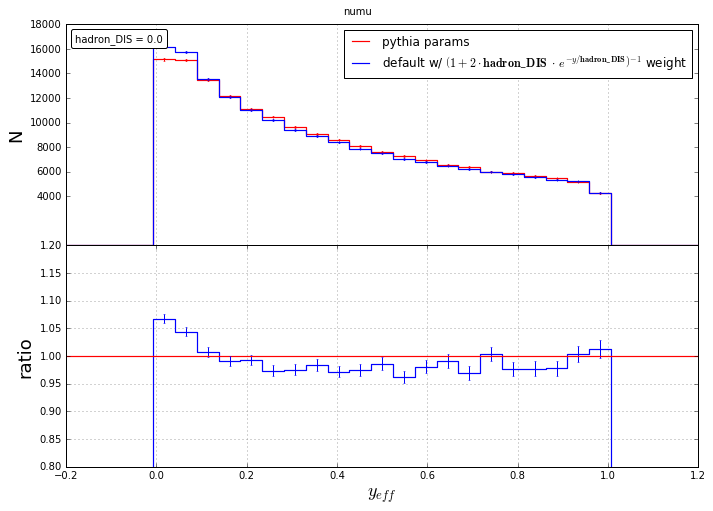

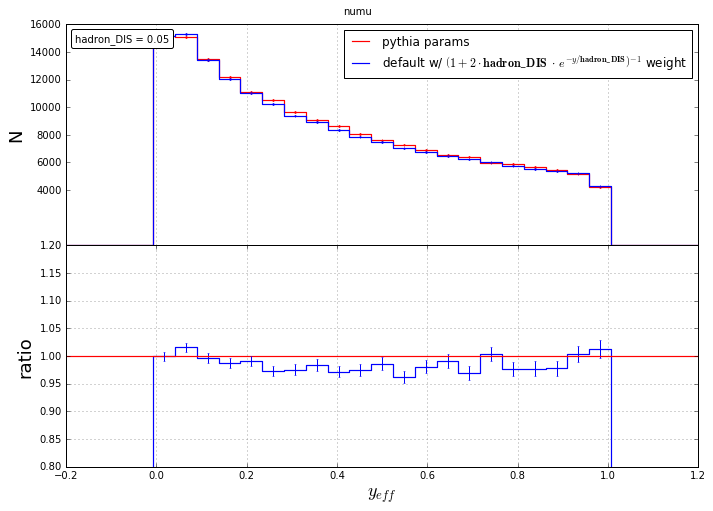

In [21]:
binning = np.linspace(-0.2, 1.2, 30)
#binning = np.logspace(-2.5, 0.1, 30)

mask_d = default_yeff > 0.001
default_yeff_m = default_yeff[mask_d]
mask_m = modified_yeff > 0.001
modified_yeff_m = modified_yeff[mask_m]

default_hist = make_histo(default_yeff_m, binning, default_dict['wght'][mask_d])
modified_hist = make_histo(modified_yeff_m, binning, modified_dict['wght'][mask_m])

a = 0.05
b = 2.*a
print(default_yeff_m)
rewght = 1./(1+b*np.exp(-default_yeff_m/a))
print(rewght)
reweighted_hist = make_histo(default_yeff_m, binning, default_dict['wght'][mask_d]*rewght)

label=r'default w/ $\left ( 1+2\cdot {\bf hadron\_DIS}\:\cdot\:e^{-y/{\bf hadron\_DIS}}\right )^{-1}$ weight'
make_plot(modified_hist, default_hist, binning, r'N', label, './nominal.png', 0.)
make_plot(modified_hist, reweighted_hist, binning, r'N', label, './test_rw.png', a)